# Baseline model

This notebook is an adaptation of the `segment_aerial_images.ipynb` notebook that was provided to in the [CS-443 course GitHub](https://github.com/epfml/ML_course/blob/master/projects/project2/project_road_segmentation/segment_aerial_images.ipynb).

It is used to train a simpler baseline models (LogisticRegression, XGBoost) to compare against the more advanced models that we use in our project.

## Google Colab

The following two cells will be necessary in Google Colab. To avoid problems with imports, they are included in the notebook.

In [ ]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # noinspection PyUnresolvedReferences
    from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
import os
import glob

# let's keep this cell at the beginning for every notebook
# for more convenient training in Google Colab
def get_root_path(filename: str) -> str: 
    """Get root path based on notebook's name."""
    filepath = glob.glob(os.getcwd() + '/**/' + filename, recursive = True)[0]
    return os.path.dirname(os.path.dirname(filepath))

ROOT_PATH = get_root_path('baseline_model.ipynb')
sys.path.append(ROOT_PATH)

# go to the drive directory
os.chdir(ROOT_PATH) if IN_COLAB else None

## Imports

In [1]:
%matplotlib inline

import os, sys
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [4]:
# Helper functions

def load_image(infilename):
    """
    Load and return an image from file.
    
    @param infilename: path to image file
    @return: image
    """
    data = mpimg.imread(infilename)
    return data


def img_float_to_uint8(img):
    """
    Convert images from float to uint8
    
    @param img: float image
    @return: uint8 image
    """
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg


def concatenate_images(img, gt_img):
    """
    Concatenate an image and its groundtruth mask
    
    @param img: original image 
    @param gt_img: ground truth mask
    @return: concatenated image+mask
    """
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)
        gt_img_3c[:, :, 0] = gt_img8
        gt_img_3c[:, :, 1] = gt_img8
        gt_img_3c[:, :, 2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg


def img_crop(im, w, h):
    """
    Crop an image to patches of specified width and height.
    
    @param im: image
    @param w: patch width
    @param h: patch height
    @return: list of patches
    """
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j : j + w, i : i + h]
            else:
                im_patch = im[j : j + w, i : i + h, :]
            list_patches.append(im_patch)
    return list_patches

In [5]:
root_dir = os.path.join(ROOT_PATH, 'data', 'raw', 'train')

# Read in all training images
image_dir = os.path.join(root_dir, 'images')
files = os.listdir(image_dir)
imgs = [load_image(os.path.join(image_dir, file)) for file in files]
print(f"Loaded {len(imgs)} images")
print(files[0])

# Read in all training masks
gt_dir = os.path.join(root_dir, 'masks')
masks = [load_image(os.path.join(gt_dir, file)) for file in files]
print(f"Loaded {len(masks)} masks")
print(files[0])


Loaded 100 images
satImage_058.png
Loaded 100 masks
satImage_058.png


Image size = 400,400


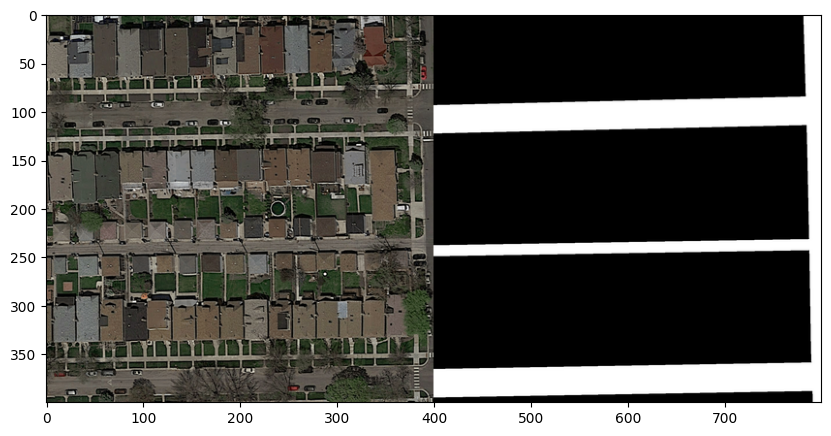

In [6]:
print("Image size = " + str(imgs[0].shape[0]) + "," + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], masks[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap="Greys_r")

In [7]:
# Extract patches from input images
patch_size = 16  # each patch is 16*16 pixels

img_patches = [img_crop(img, patch_size, patch_size) for img in imgs]
mask_patches = [img_crop(mask, patch_size, patch_size) for mask in masks]

# Linearize list of patches
img_patches = np.asarray(
    [
        img_patches[i][j]
        for i in range(len(img_patches))
        for j in range(len(img_patches[i]))
    ]
)
mask_patches = np.asarray(
    [
        mask_patches[i][j]
        for i in range(len(mask_patches))
        for j in range(len(mask_patches[i]))
    ]
)

In [8]:
def extract_features(img):
    """
    Extract 6-dimensional features consisting of average RGB color as well as variance
    
    @param img: input image 
    @return: numpy nd_array with extracted features
    """
    feat_m = np.mean(img, axis=(0, 1))
    feat_v = np.var(img, axis=(0, 1))
    feat = np.append(feat_m, feat_v)
    return feat

def extract_img_features(filename):
    """
    Extract features for a given image    
    
    @param filename: full filename of image
    @return: numpy nd_array of initial image with extracted features on additional dimensions 
    """
    
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray(
        [extract_features(img_patches[i]) for i in range(len(img_patches))]
    )
    return X

In [9]:
foreground_threshold = (
    0.25  # percentage of pixels > 1 required to assign a foreground label to a patch
)


def value_to_class(v):
    """
    Assign {0,1} class to patch represented as numpy array based on the 
        threshold of pixels that need to be classified as road.
    
    @param v: image patch as array
    @return: class
    """
    
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

# Extract features for training set images
X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
# Generate classification for each prediction patch
Y = np.asarray([value_to_class(np.mean(mask_patches[i])) for i in range(len(mask_patches))])

## Train Logistic Regression model

In [10]:
from sklearn import linear_model
from sklearn import ensemble
from flaml import AutoML

def create_models():
    """
    Initialize the baseline models
    
    @return: a dictionary of models, ready for training 
    """
    models = {}
    
    #### Create LogisticRegression model
    logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
    models["LogisticRegression"] = logreg
    
    #### Create GradientBoostingClassifier model
    gdboost = ensemble.GradientBoostingClassifier(
        n_estimators=50, learning_rate=1.0, max_depth=10, random_state=0
    )
    models["GradientBoostingClassifier"] = gdboost
    
    
    #### Create AutoML model for XGBoost
    settings = {
        "time_budget": 60,  # total running time in seconds
        "metric": 'mse',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
        "estimator_list": ['xgboost'],  # list of ML learners; we tune XGBoost in this example
        "task": 'classification',  # task type
        "seed": 7654321,  # random seed
    }

    automl = AutoML(**settings)
    models["XGBoost"] = automl
    
    return models

In [11]:
def label_to_img(imgwidth, imgheight, w, h, labels):
    """
    Convert array of labels to an image for visualization by mapping patches back into full image resolution.
    
    @param imgwidth: width of the mask
    @param imgheight: height of the mask
    @param w: width of the patch
    @param h: height of the patch
    @param labels: predictions
    @return: prediction as image
    """
    
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            im[j : j + w, i : i + h] = labels[idx]
            idx = idx + 1
    return im


def make_img_overlay(img, predicted_img):
    """
    Overlay road/background prediction to image.
    
    @param img: real satellite image
    @param predicted_img: prediction layer image
    @return: 
    """
    
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:, :, 0] = predicted_img * 255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, "RGB").convert("RGBA")
    overlay = Image.fromarray(color_mask, "RGB").convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img


k-fold=0


Model: LogisticRegression
Training model
f1 score is 0.461
True positive rate = 0.175
accuracy score is 0.589

Model: GradientBoostingClassifier
Training model
f1 score is 0.478
True positive rate = 0.117
accuracy score is 0.745

Model: XGBoost
Training model
[flaml.automl.logger: 12-19 17:39:47] {1679} INFO - task = classification
[flaml.automl.logger: 12-19 17:39:47] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-19 17:39:47] {1788} INFO - Minimizing error metric: mse
[flaml.automl.logger: 12-19 17:39:47] {1900} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 12-19 17:39:47] {2218} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 12-19 17:39:47] {2344} INFO - Estimated sufficient time budget=116s. Estimated necessary time budget=0s.
[flaml.automl.logger: 12-19 17:39:47] {2391} INFO -  at 0.0s,	estimator xgboost's best error=0.2610,	best estimator xgboost's best error=0.2610
[flaml.automl.logger: 12-19 17:39:4

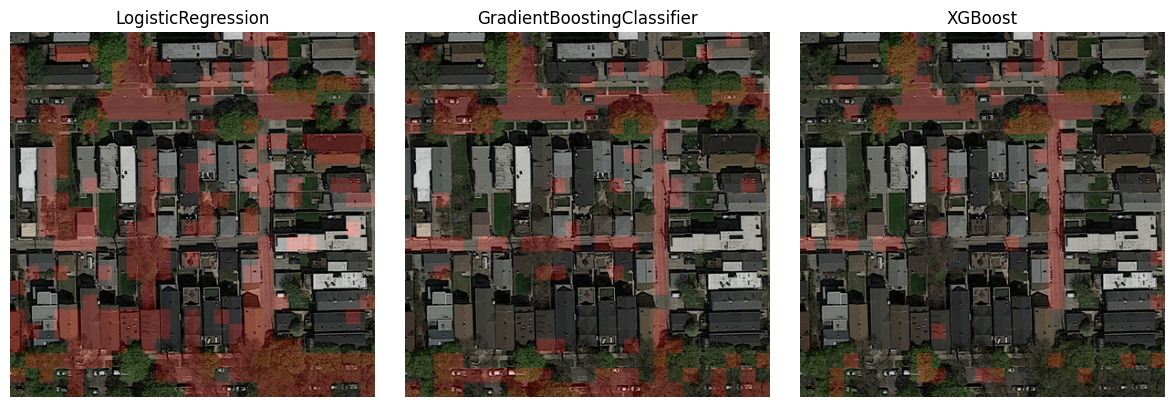

In [15]:
def visualize_predictions(models, image_dir, files, img_idx = 12):
    """
    Visualize the predictions of the different models as an overlay on a training set image
    
    @param models: dictionary of trained models
    @param image_dir: directory where the training set images are located
    @param files: list image_dir contents
    @param img_idx: index of the image (from training set) used for visualization
    @return: None
    """
    
    fig = plt.figure(layout='tight', figsize=(12, 4))
    
    # Generate prediction example for each model
    for i, (name, model) in enumerate(models.items()):
        # Read picture and predict
        Xi = extract_img_features( os.path.join(image_dir, files[img_idx]))
        Zi = model.predict(Xi)
        
        # Create prediction overlay
        w = masks[img_idx].shape[0]
        h = masks[img_idx].shape[1]
        predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
        new_img = make_img_overlay(imgs[img_idx], predicted_im)
        
        # Add image to figure
        ax = fig.add_subplot(1, 3, i+1)
        ax.imshow(new_img)
        ax.set_title(name)
        ax.axis("off")


K_FOLDS = 3
MODEL_COUNT = 3

# Results matrices, where each row contains the results of one fold, and each column represents a specific model.
f1_results = np.empty((K_FOLDS, MODEL_COUNT))
accuracy_results = np.empty((K_FOLDS, MODEL_COUNT))
TPR_results = np.empty((K_FOLDS, MODEL_COUNT))

k_fold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(k_fold.split(X)):
    # Create fresh models at the start of each fold
    models = create_models()
    print(f"\nk-fold={fold}\n")
    
    # Train and test all models on current fold's data
    for model_idx, (name, model) in enumerate(models.items()):
        print(f"\nModel: {name}")
        print("Training model")
        model.fit(X[train_idx], Y[train_idx])
        
        # Predict on the training set
        pred = model.predict(X[val_idx])
        
        # Get non-zeros in prediction and grountruth arrays
        pred_nonzero = np.nonzero(pred)[0]
        Y_nonzero = np.nonzero(Y[val_idx])[0]
        
        # Print scores
        f1 = f1_score(Y[val_idx], pred, zero_division='warn')
        print(f"f1 score is {round(f1, 3)}")
        
        TPR = len(list(set(Y_nonzero) & set(pred_nonzero))) / float(len(pred))
        print("True positive rate = " + str(round(TPR, 3)))
        
        accuracy = accuracy_score(Y[val_idx], pred)
        print(f"accuracy score is {round(accuracy, 3)}")
        
        # Save fold and model results for later aggregation 
        f1_results[fold][model_idx] = f1
        accuracy_results[fold][model_idx] = accuracy
        TPR_results[fold][model_idx] = TPR
    
    #### Show prediction on example image after last fold
    if fold == K_FOLDS-1:
        visualize_predictions(models, image_dir, files)
    

In [16]:
# Aggregate cross-validation results into a pandas dataframe

result_matrix = np.array([f1_results.mean(axis=0), accuracy_results.mean(axis=0), TPR_results.mean(axis=0)])
df = pd.DataFrame(result_matrix.T, columns=["F1", "Accuracy", "True Positive Rate"])
df.insert(0, "Model", models.keys())
df

,Model,F1,Accuracy,True Positive Rate
0,LogisticRegression,0.460160,0.587856,0.175648
1,GradientBoostingClassifier,0.479224,0.745104,0.117280
2,XGBoost,0.507131,0.791696,0.107168


In [17]:
# Generate latex table of aggregated cross-validation results for report

print(df.to_latex(columns=["Model", "F1", "Accuracy", "True Positive Rate"], caption="Baseline model performance (mean values over k-fold cross-validation)", label="table:baseline-results", position="h!", index=False, float_format="%.3f"))

\begin{table}[h!]
\caption{Baseline model performance (mean values over k-fold cross-validation)}
\label{table:baseline-results}
\begin{tabular}{lrrr}
\toprule
Model & F1 & Accuracy & True Positive Rate \\
\midrule
LogisticRegression & 0.460 & 0.588 & 0.176 \\
GradientBoostingClassifier & 0.479 & 0.745 & 0.117 \\
XGBoost & 0.507 & 0.792 & 0.107 \\
\bottomrule
\end{tabular}
\end{table}
